# DATA PREPARATION

In [4]:
import pandas as pd
heart_dataset:pd.DataFrame = pd.read_csv("~/git/thesis_thallasemia/heartv1.csv", header=0)
df:pd.DataFrame = heart_dataset.copy()

# renamed the headers(target to "heart disease diagnosis(old target)" and thal to "target(thal)")
df.rename(columns={
	'target': 'heart disease diagnosis',
	'thal': 'target(thal)',
	'sex': 'is_male'
}, inplace=True)

# Map sex to binary
df['is_male'] = df['is_male'].map({'male': 1, 'female': 0})

# Drop rows with missing values if any
df.dropna(inplace=True)

# Define features and target
x:pd.DataFrame = df.drop(columns=['target(thal)'])  #used to predict column
y:pd.Series = df['target(thal)']  #target column

# training and testing split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# FEATURE IMPORTANCE
### RANDOM FOREST TRAINING & DETAILS

In [3]:
from sklearn.ensemble import RandomForestClassifier

# initialized the classifier object
clf:RandomForestClassifier = RandomForestClassifier(random_state=42)
# trains the classifier object with the training data
clf.fit(x_train, y_train)

# Get feature importance
feature_importance_df: pd.DataFrame = pd.DataFrame({
    'feature': clf.feature_names_in_,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
13,Heart Disease Risnume,0.120602
9,oldpeak,0.104883
14,heart disease diagnosis,0.099129
7,thalach,0.094688
4,chol,0.093843
3,resting_BP,0.087437
12,Max Heart Rate Reserve,0.086227
1,age,0.078456
2,cp,0.054921
0,is_male,0.053685


### DECISION TREES TRAINING & DETAILS

In [7]:
from sklearn.tree import DecisionTreeClassifier

# initialized the classifier object
model_dt:DecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
# trains the classifier object with the training data
model_dt.fit(x_train, y_train)

# Get feature importance
feature_importance_dt: pd.DataFrame = pd.DataFrame({
    'feature': model_dt.feature_names_in_,
    'importance': model_dt.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance_dt

,feature,importance
14,heart disease diagnosis,0.209875
13,Heart Disease Risnume,0.129596
4,chol,0.114734
12,Max Heart Rate Reserve,0.107855
7,thalach,0.104914
9,oldpeak,0.101584
1,age,0.062238
3,resting_BP,0.054817
0,is_male,0.036372
11,ca,0.033122


# SHAPLEY VALUES

In [ ]:
import shap

# Create a SHAP explainer for the trained RandomForest model
explainer = shap.TreeExplainer(clf)

# Compute SHAP values for the test set
shap_values = explainer(x)

# Plot SHAP summary for class 1 (you can adjust depending on output shape)
# shap.summary_plot(shap_values[:, :, -1], x_test)
# shap.summary_plot(shap_values[:,:0], x_test, feature_names=x_test.columns)


In [ ]:
import numpy as np

np.shape(shap_values.values)

(1035, 15, 4)

/home/jules/venv_shap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 95%|=================== | 984/1036 [00:15<00:00]       

[ 1.66666668e-03 -1.84174602e-03 -1.39428571e-03  2.86349218e-04
 -1.98496033e-03 -8.69127003e-04 -1.95626985e-03 -7.04269834e-03
  9.75000010e-05  1.68527780e-03  1.08611112e-04  1.66809527e-03
 -4.65488095e-03  4.09432540e-03 -1.62857143e-04]


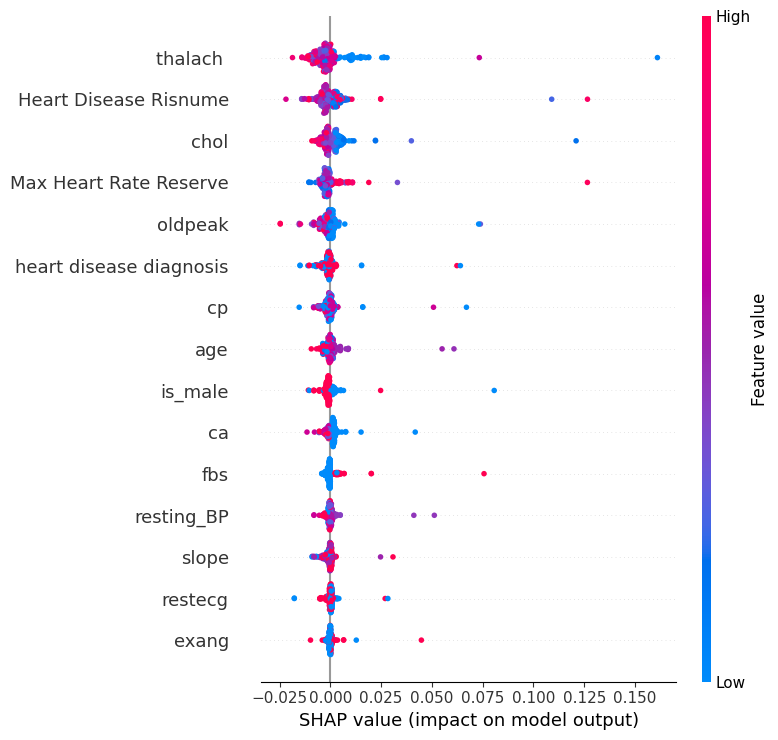

      is_male       age        cp  resting_BP      chol       fbs   restecg  \
294  0.001667 -0.001842 -0.001394    0.000286 -0.001985 -0.000869 -0.001956   
453  0.000890 -0.001314 -0.000633   -0.001052  0.002539 -0.000535 -0.000342   
638  0.003224 -0.000555  0.001888    0.001817 -0.002258 -0.000099 -0.001149   
139  0.000803 -0.002239 -0.001273   -0.001055  0.002529 -0.000461 -0.000267   
539 -0.000574 -0.003844 -0.005998    0.000389 -0.002388  0.003839 -0.000095   

     thalach      exang   oldpeak     slope        ca  Max Heart Rate Reserve  \
294 -0.007043  0.000098  0.001685  0.000109  0.001668               -0.004655   
453 -0.009136 -0.000197 -0.000784  0.000203  0.001299               -0.002980   
638  0.016498  0.000251 -0.009278 -0.008949 -0.000892                0.009635   
139 -0.000103 -0.000142 -0.002956 -0.001124  0.001084               -0.001310   
539  0.000809 -0.000984 -0.000546  0.000196 -0.000804               -0.002318   

     Heart Disease Risnume  heart dise

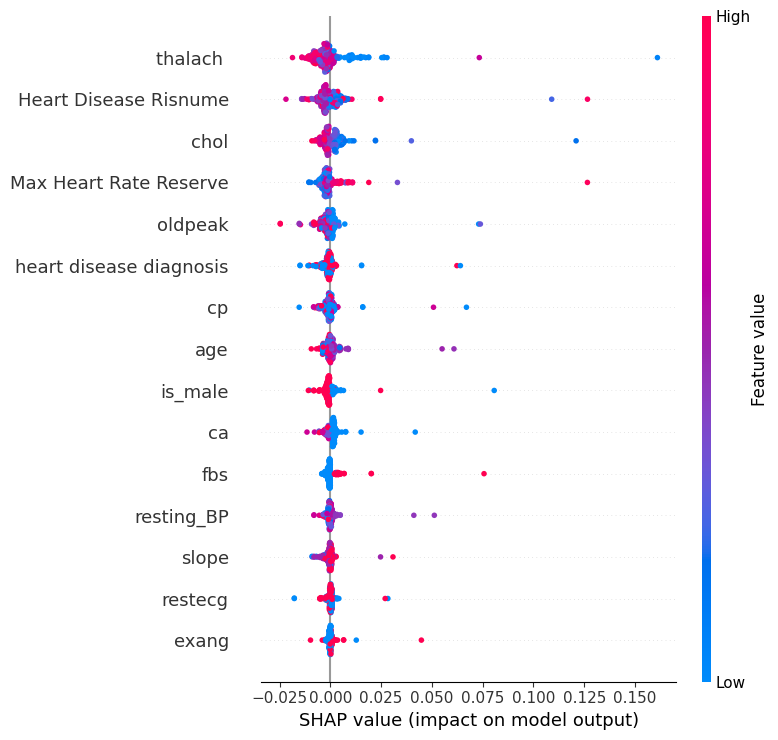

In [ ]:
import shap


# Get SHAP values
explainer = shap.Explainer(clf, x_train)
shap_values = explainer(x_test)

# Example: SHAP values for first instance, class 0
print(shap_values[0].values[:, 0])

# Optional: summary plot for class 0
shap.summary_plot(shap_values[:, :, 0], x_test)

# Build SHAP value table for class 0
shap_df = pd.DataFrame(
    shap_values.values[:, :, 0],  # <-- class index here
    columns=x_test.columns,
    index=x_test.index
)

# Optionally add actual and predicted values
shap_df['actual'] = y_test.values
shap_df['predicted_label'] = clf.predict(x_test)
shap_df['predicted_proba_class0'] = clf.predict_proba(x_test)[:, 0]

# Show first few rows
print(shap_df.head())

# Optional: summary plot again (optional duplicate)
shap.summary_plot(shap_values[:, :, 0], x_test)

In [ ]:
shap.plots.waterfall(shap_values[0,0])

TypeError: only length-1 arrays can be converted to Python scalars